# Library installations and imports

Install the 🤗 library

In [103]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import transformers
print(transformers.__version__)

4.20.1


In [105]:
from transformers import BertTokenizer, BertModel, pipeline

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

import nltk
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data Preprocessing

In [106]:
#Import the dataset
financedf = pd.read_csv('data.csv')

In [107]:
#Check the shape of the dataset
print("Data size \n", financedf.shape )
print()

Data size 
 (5842, 2)



In [108]:
#Print the first few rows of the dataset
financedf.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [109]:
#Check the number of duplicated rows
financedf['Sentence'].duplicated().sum()

520

In [110]:
#Drop the duplicates
financedf.drop_duplicates('Sentence', keep='first')
financedf.shape

(5842, 2)

In [111]:
#View data information
financedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [112]:
#Display a few positive tweets
print("Positive Tweet Samples: -\n")
for tweet in range(5):
  print(financedf[financedf.Sentiment == 'positive']['Sentence'].iloc[tweet])

Positive Tweet Samples: -

The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
$SPY wouldn't be surprised to see a green close
Kone 's net sales rose by some 14 % year-on-year in the first nine months of 2008 .
Circulation revenue has increased by 5 % in Finland and 4 % in Sweden in 2008 .


In [113]:
print("Neutral Tweet Samples: -\n")
for tweet in range(5):
  print(financedf[financedf.Sentiment == 'neutral']['Sentence'].iloc[tweet])

Neutral Tweet Samples: -

According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .
The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .
The Stockmann department store will have a total floor space of over 8,000 square metres and Stockmann 's investment in the project will have a price tag of about EUR 12 million .
Viking Line has canceled some services .
Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company 's stock option programs I 2001 and II 2001 .


In [114]:
print("Negative Tweet Samples: -\n")
for tweet in range(5):
  print(financedf[financedf.Sentiment == 'negative']['Sentence'].iloc[tweet])

Negative Tweet Samples: -

$ESI on lows, down $1.50 to $2.50 BK a real possibility
Shell's $70 Billion BG Deal Meets Shareholder Skepticism
SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .
$SAP Q1 disappoints as #software licenses down. Real problem? #Cloud growth trails $MSFT $ORCL $GOOG $CRM $ADBE https://t.co/jNDphllzq5
$AAPL afternoon selloff as usual will be brutal. get ready to lose a ton of money.


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


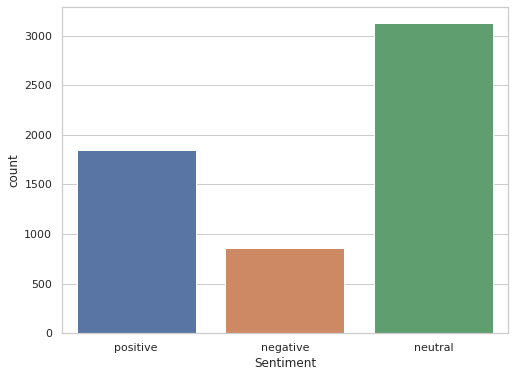

In [115]:
#Plot a bar chart to show the total number of positive, neutral and negative tweets
sns.set_theme(style='whitegrid')
print(financedf["Sentiment"].value_counts())
sns.countplot(x=financedf.Sentiment);

In [116]:
#Encode the sentiments to 0,1,2
labelencoder = LabelEncoder()
financedf['Sentiment'] = labelencoder.fit_transform(financedf['Sentiment'])

In [117]:
labelencoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [118]:
financedf.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


In [119]:
#Import the bert-base-uncased tokenizer from BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [120]:
#Download the stopwordsin the english language
stopWords = set(stopwords.words("english"))

In [121]:
#Perform data preprocessing
def preprocess(text):
  text = text.lower()
  text = word_tokenize(str(text))
  text = [re.sub('[^A-Za-z]+', '', word) for word in text]
  text = [t for t in text if t not in stopWords]
  text = [WordNetLemmatizer().lemmatize(t) for t in text]
  text = [PorterStemmer().stem(t) for t in text]
  text = ' '.join(text)

  return text

In [122]:
#Display the preprocessed text
financedf["Sentence"] = financedf["Sentence"].apply(preprocess)
financedf["Sentence"].head()

0    geosolut technolog leverag benefon gp solut pr...
1                         esi low      bk real possibl
2    last quarter   componenta net sale doubl eurm ...
3    accord finnishrussian chamber commerc  major c...
4    swedish buyout firm sold remain  percent stake...
Name: Sentence, dtype: object

In [123]:
financedf["Sentence"][12]

'subdivis made sale revenu last year eur  million eur  million   oper profit eur  million eur  million '

# BERT Modeling

In [124]:
#Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(financedf["Sentence"], financedf["Sentiment"], test_size=.3)

In [125]:
len(X_train)

4089

In [126]:
y_train

5068    1
4571    1
1505    1
1179    1
1722    2
       ..
4110    2
4767    0
4493    1
519     1
416     1
Name: Sentiment, Length: 4089, dtype: int64

In [127]:
X_train.head()

5068      cargo traffic fell   yearonyear  tonn septemb  
4571    oper profit exclud nonrecur item decreas eur  ...
1505                earn per share  ep  amount loss eur  
1179    accord origin merger plan  scanfil would get  ...
1722    alert  new macd signal creat  ctx  buy   time ...
Name: Sentence, dtype: object

In [128]:
#Use the bert tokenizer to prepare inputs for the model
trainEncoded = tokenizer(X_train.tolist(), add_special_tokens = True, padding='max_length', truncation=True, max_length=280, 
                                 return_token_type_ids=False, return_tensors = 'pt')
testEncoded = tokenizer(X_test.tolist(), add_special_tokens = True, padding='max_length', truncation=True, max_length=280, 
                                 return_token_type_ids=False, return_tensors = 'pt')

In [129]:
#View the keys
trainEncoded.keys()

dict_keys(['input_ids', 'attention_mask'])

In [130]:
#Decode a sample sentence
tokenizer.decode(trainEncoded["input_ids"][3])

'[CLS] accord origin merger plan scanfil would get stake combin busi [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [131]:
#Get input_ids and attention_mask of the train and test dataset
input_ids_train = trainEncoded['input_ids']
attention_masks_train = trainEncoded["attention_mask"]

input_ids_test = testEncoded['input_ids']
attention_masks_test = testEncoded["attention_mask"]

In [132]:
#Create the training and testing dataset
trainDataset = TensorDataset(input_ids_train, attention_masks_train, torch.tensor(y_train.values))
testDataset = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(y_test.values))

In [133]:
len(trainDataset),len(testDataset)

(4089, 1753)

In [134]:
#Combine the training and testing dataset with a sampler
trainDataloader = DataLoader(trainDataset, sampler=RandomSampler(trainDataset), batch_size=16)
testDataloader = DataLoader(testDataset, sampler=RandomSampler(testDataset), batch_size=32)

In [135]:
next(iter(trainDataset))

(tensor([  101,  6636,  4026,  3062,  2095, 16585, 14644, 10228,  2078, 17419,
          6633,  2497,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 10
num_classes = 3

In [137]:
print(device)

cuda


In [138]:
#Create the transformer neural network
class BERTClassification(nn.Module):
  def __init__ (self, n_classes):
    super(BERTClassification, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.bert_drop = nn.Dropout(0.4)
    self.out = nn.Linear(768, n_classes)
  
  def forward(self,input_ids, attention_mask):
    _, pooledOut = self.bert(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
    bertOut = self.bert_drop(pooledOut)
    output = self.out(bertOut)
    
    return output

In [139]:
#Helper function to count the parameters
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [140]:
#Create the model
model = BERTClassification(num_classes)
model = model.to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The model has 109,484,547 trainable parameters


In [141]:
model

BERTClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [142]:
#Training function
def train(model, dataloader, optimizer, criterion, clip=1.0):

    model.train()

    ep_t_loss = 0
    batch_num  = 0
    pred, targets = [], []
    for ix, batch in tqdm(enumerate(dataloader)):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attn_mask, y = batch
        
        #Update weights
        optimizer.zero_grad()
        
        #Make predictions
        output = model(input_ids, attn_mask)  

        #Calculate loss   
        loss = criterion(output, y)
        loss.backward()

        #Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        ep_t_loss += loss.item()
        batch_num += 1
        pred.extend(torch.argmax(output, -1).tolist())
        targets.extend(y.tolist())

    return ep_t_loss/batch_num, metrics.f1_score(targets, pred, average='macro')

#Evaluation function
def evaluate(model, dataloader, criterion):

    model.eval()

    ep_t_loss = 0
    batch_num  = 0
    pred, targets = [], []
    for ix, batch in enumerate(dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attn_mask, y = batch

        with torch.no_grad():
            output = model(input_ids, attn_mask)
            
            loss = criterion(output, y)

            ep_t_loss += loss.item()
            batch_num += 1
            pred.extend(torch.argmax(output, -1).tolist())
            targets.extend(y.tolist())
        
    return ep_t_loss/batch_num, metrics.f1_score(targets, pred, average='macro'), pred, targets

In [143]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr = 2e-5)

In [144]:
bestTestLoss = float('inf')
trainLoss, testLoss =[], []
trainAcc, testAcc = [], []

In [145]:
for epoch in tqdm(range(EPOCH)): 

    train_loss, train_f1= train(model, trainDataloader, optim, criterion)
    trainLoss.append(train_loss)
    trainAcc.append(train_f1)

    test_loss, test_f1, pred, targets = evaluate(model, testDataloader, criterion)
    testLoss.append(test_loss)
    testAcc.append(test_f1)
    
    if test_loss < bestTestLoss:
        bestTestLoss = test_loss
        best_pred, best_targets = pred, targets
        torch.save(model.state_dict(), 'model_least_loss.pt')
        print("\nBest Model Saved !!")
    elif epoch % 3 == 0:
        torch.save(model.state_dict(), 'model_checkpoint_'+str(epoch)+'.pt')
        print("\Checkpoint Model Saved !!")
    print("\n")
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Total Loss: {train_loss:.3f} | Train F1: {train_f1:.3f}')
    print(f'\tVal. Total Loss: {test_loss:.3f} | Test F1: {test_f1:.3f}')
    print("_________________________________________________________________")

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.11it/s]
2it [00:01,  1.20it/s]
3it [00:02,  1.27it/s]
4it [00:03,  1.27it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.31it/s]
7it [00:05,  1.33it/s]
8it [00:06,  1.34it/s]
9it [00:06,  1.33it/s]
10it [00:07,  1.35it/s]
11it [00:08,  1.36it/s]
12it [00:09,  1.35it/s]
13it [00:09,  1.36it/s]
14it [00:10,  1.35it/s]
15it [00:11,  1.36it/s]
16it [00:12,  1.36it/s]
17it [00:12,  1.36it/s]
18it [00:13,  1.37it/s]
19it [00:14,  1.38it/s]
20it [00:14,  1.38it/s]
21it [00:15,  1.38it/s]
22it [00:16,  1.38it/s]
23it [00:17,  1.39it/s]
24it [00:17,  1.39it/s]
25it [00:18,  1.39it/s]
26it [00:19,  1.39it/s]
27it [00:19,  1.39it/s]
28it [00:20,  1.39it/s]
29it [00:21,  1.39it/s]
30it [00:22,  1.38it/s]
31it [00:22,  1.38it/s]
32it [00:23,  1.39it/s]
33it [00:24,  1.38it/s]
34it [00:25,  1.38it/s]
35it [00:25,  1.38it/s]
36it [00:26,  1.38it/s]
37it [00:27,  1.38it/s]
38it [00:27,  1.37it/s]
39it [00:28,  1.37it/s]
40it [00:29,  1


Best Model Saved !!


Epoch: 01
	Train Total Loss: 0.912 | Train F1: 0.414
	Val. Total Loss: 0.798 | Test F1: 0.448
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.35it/s]
2it [00:01,  1.32it/s]
3it [00:02,  1.31it/s]
4it [00:03,  1.31it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:09,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.30it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.30it/s]
36it [00:27,  1.29it/s]
37it [00:28,  1.29it/s]
38it [00:29,  1.29it/s]
39it [00:30,  1.29it/s]
40it [00:30,  1.29it/s]
41it [00:31,  1.30it/s]
42it 


Best Model Saved !!


Epoch: 02
	Train Total Loss: 0.684 | Train F1: 0.600
	Val. Total Loss: 0.643 | Test F1: 0.627
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.34it/s]
2it [00:01,  1.31it/s]
3it [00:02,  1.31it/s]
4it [00:03,  1.31it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:09,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.30it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:19,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.30it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.30it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.30it/s]
42it 



Epoch: 03
	Train Total Loss: 0.473 | Train F1: 0.732
	Val. Total Loss: 0.682 | Test F1: 0.631
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.31it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:10,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.29it/s]
18it [00:13,  1.29it/s]
19it [00:14,  1.29it/s]
20it [00:15,  1.29it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.29it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.30it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.30it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.30it/s]
42it 

\Checkpoint Model Saved !!


Epoch: 04
	Train Total Loss: 0.352 | Train F1: 0.792
	Val. Total Loss: 0.905 | Test F1: 0.609
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.34it/s]
2it [00:01,  1.32it/s]
3it [00:02,  1.31it/s]
4it [00:03,  1.31it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:09,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.30it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.29it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.29it/s]
36it [00:27,  1.29it/s]
37it [00:28,  1.29it/s]
38it [00:29,  1.29it/s]
39it [00:30,  1.29it/s]
40it [00:30,  1.29it/s]
41it [00:31,  1.30it/s]
42it 



Epoch: 05
	Train Total Loss: 0.293 | Train F1: 0.826
	Val. Total Loss: 1.051 | Test F1: 0.627
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.30it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:10,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.30it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.30it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.30it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.30it/s]
42it 



Epoch: 06
	Train Total Loss: 0.250 | Train F1: 0.843
	Val. Total Loss: 1.056 | Test F1: 0.654
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.30it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.29it/s]
10it [00:07,  1.29it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:10,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.29it/s]
18it [00:13,  1.29it/s]
19it [00:14,  1.29it/s]
20it [00:15,  1.29it/s]
21it [00:16,  1.29it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.30it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.30it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.30it/s]
42it 

\Checkpoint Model Saved !!


Epoch: 07
	Train Total Loss: 0.218 | Train F1: 0.859
	Val. Total Loss: 1.207 | Test F1: 0.646
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.30it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:10,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.30it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.30it/s]
30it [00:23,  1.30it/s]
31it [00:23,  1.30it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.30it/s]
35it [00:26,  1.30it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.30it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.30it/s]
42it 



Epoch: 08
	Train Total Loss: 0.219 | Train F1: 0.859
	Val. Total Loss: 1.203 | Test F1: 0.634
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.32it/s]
2it [00:01,  1.31it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:10,  1.30it/s]
14it [00:10,  1.30it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.30it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.30it/s]
28it [00:21,  1.30it/s]
29it [00:22,  1.29it/s]
30it [00:23,  1.29it/s]
31it [00:23,  1.29it/s]
32it [00:24,  1.30it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.29it/s]
35it [00:26,  1.29it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.29it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.29it/s]
42it 



Epoch: 09
	Train Total Loss: 0.199 | Train F1: 0.865
	Val. Total Loss: 1.554 | Test F1: 0.620
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.31it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.30it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]
8it [00:06,  1.30it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.30it/s]
11it [00:08,  1.30it/s]
12it [00:09,  1.30it/s]
13it [00:10,  1.30it/s]
14it [00:10,  1.29it/s]
15it [00:11,  1.30it/s]
16it [00:12,  1.30it/s]
17it [00:13,  1.29it/s]
18it [00:13,  1.30it/s]
19it [00:14,  1.30it/s]
20it [00:15,  1.30it/s]
21it [00:16,  1.30it/s]
22it [00:16,  1.30it/s]
23it [00:17,  1.30it/s]
24it [00:18,  1.30it/s]
25it [00:19,  1.30it/s]
26it [00:20,  1.30it/s]
27it [00:20,  1.29it/s]
28it [00:21,  1.29it/s]
29it [00:22,  1.29it/s]
30it [00:23,  1.29it/s]
31it [00:23,  1.29it/s]
32it [00:24,  1.29it/s]
33it [00:25,  1.30it/s]
34it [00:26,  1.29it/s]
35it [00:27,  1.30it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.30it/s]
38it [00:29,  1.30it/s]
39it [00:30,  1.30it/s]
40it [00:30,  1.30it/s]
41it [00:31,  1.30it/s]
42it 

\Checkpoint Model Saved !!


Epoch: 10
	Train Total Loss: 0.189 | Train F1: 0.873
	Val. Total Loss: 1.554 | Test F1: 0.598
_________________________________________________________________


# Results

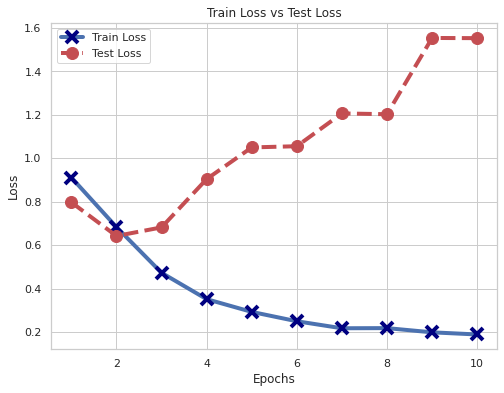

In [147]:
#Print the Train loss vs Test loss chart
epochs = range(1,EPOCH+1)
plt.plot(epochs, trainLoss, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
plt.plot(epochs, testLoss, 'r--o', linewidth=4, markersize=12,);
plt.title('Train Loss vs Test Loss')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epochs'); plt.ylabel('Loss');

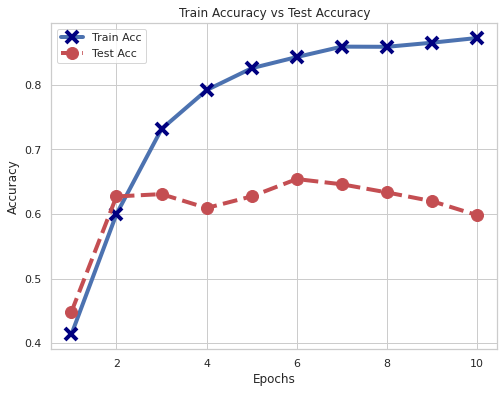

In [148]:
#Print the Train accuracy vs Test accuracy chart
epochs = range(1,EPOCH+1)
plt.plot(epochs, trainAcc, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
plt.plot(epochs, testAcc, 'r--o', linewidth=4, markersize=12,);
plt.title('Train Accuracy vs Test Accuracy')
plt.legend(['Train Acc', 'Test Acc'])
plt.xlabel('Epochs'); plt.ylabel('Accuracy');

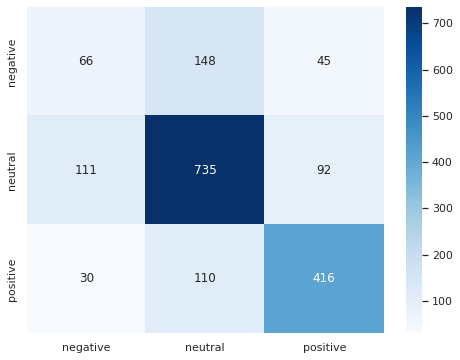

In [149]:
#Print the confusion matrix
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
cf_matrix = confusion_matrix(targets, pred)
sns.heatmap(cf_matrix,annot=True,cmap='Blues',fmt="g",xticklabels=labelencoder.classes_,yticklabels=labelencoder.classes_);

# References



1.   https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial
2.   https://mccormickml.com/2019/07/22/BERT-fine-tuning/#4-train-our-classification-model
3. https://www.kaggle.com/datasets/davidwallach/financial-tweets

